# Template Data Analysis Workflow - Visualization and kinetic modeling of enzymatic data

### Imports
Import packages needed for data analysis

In [1]:
#import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver

from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting

from pyenzyme import EnzymeMLDocument # EnzymeML document functionalities

## Select EnzymeML document
Select the EnzymeML document, by changing the path variable accodingly. <br>
The EnzymeML document will be stored in the enzmldoc variable. <br>

In [2]:
# If the document is a EnzymeML document 
#enzmldoc = EnzymeMLDocument.fromFile('path_to.omex')

# If the document is from a spreadsheet 
enzmldoc = EnzymeMLDocument.fromTemplate('./Spreadsheet_UPO_corrected.xlsm')

## Print the Document to get a first overview

To get a first overview of the experiment. Information like IDs from reactants are printed.

In [3]:
# With measurements=True in parenthesis we can also print out the initial concentrations 
enzmldoc.printDocument()

 UPO mediated oxidation
>>> Reactants
	ID: s0 	 Name: 1.3-bisphenoxypropan-2-ol
	ID: s1 	 Name: H2O2
	ID: s2 	 Name: unknown degradation products
	ID: s3 	 Name: H2O
	ID: s4 	 Name: L-ascorbic acid
>>> Proteins
	ID: p0 	 Name: rAaeUPO (PaDa-I)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: UPO-mediated oxidation of 1.3-bisphenoxypropan-2-ol


## Visualization of time-course data
A short visualisation to get a first impression of the data. <br>

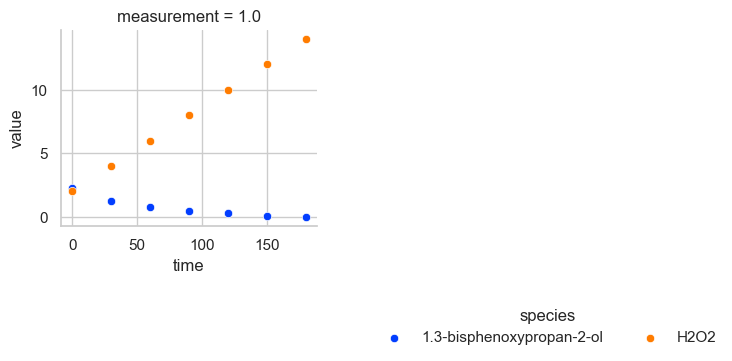

In [4]:
#basic/general settings for Seaborn
sns.set_theme(style='whitegrid', palette ='bright',color_codes=True, context = 'notebook')

enzmldoc.visualize(use_names=True)

## Prepare the data for modeling

Which Reactant should be modeled? This information can be seen in the output of printDocument()

In [5]:
reactant_id = 's0'

In [6]:
# Check if reactant_id is present
if reactant_id not in enzmldoc.getSpeciesIDs():
    print('Species not present')
    
# Exports species specific measurement data (dictionary)
measurement_data = enzmldoc.exportMeasurementData(species_ids=reactant_id)

# Concatenate data to a single DataFrame
measurement_data = pd.concat([meas["data"] for meas in measurement_data.values()])

# Separate time and actual values to ndarrays
# Reshape to match measurements
time = measurement_data.time.values.reshape(-1, len(measurement_data.time.values))[0, :] # "-1" because it's an unknown dimension and we want numpy to figure it out
measurement_data = measurement_data[reactant_id].values.reshape(-1, len(measurement_data[reactant_id].values))[0, :] # -> converts 2D array to 1D  

#print(f"Shape of data: {measurement_data.shape}\nShape of time: {time.shape}")

In [12]:
measurement_data

array([2.27940386, 1.23177972, 0.76897022, 0.49474677, 0.29908216,
       0.04616504, 0.00590414])

## Kinetic modeling and parameter estimation

#### Functions that are needed in order to perform curve fitting

Execute this cell

In [7]:
# Integrate the values to fit the data to cocentration over time
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(model, w0, t, args=(params,))
    return w


# Compute residual between actual data (S) and fitted data, if data array has more than one dimension
def residual(params, t, measurement_data):
    
    ndata, nt = measurement_data.shape    # Get dimensions of data 
    resid = 0.0 * measurement_data[:]     # Initialize the residual vector
    
    # Compute residual per data set
    for i in range(ndata):
        
        w0 = measurement_data[i,0]
        model = g(t, w0, params) # Solve the ODE with the given parameters
        
        # Get modeled substrate data
        s_model = model[:,0]
        resid[i,:]=measurement_data[i,:]-s_model # Compute distance to measured data
        
    return resid.flatten() # Return residuals


# This function gets called for residual calculation, if data array is one dimensional
def residual_single(params, t, measurement_data):
    
    w0 = measurement_data[0] # First value of measurement
    model = g(t, w0, params) # g -> solving ODE 
    
    s_model = model[:,0] # 0th column
    
    return (s_model - measurement_data).ravel() # Return residuals


# Perform modeling
def perform_modeling(measurement_data, time, params):
    if len(measurement_data.shape)>1:
        result = minimize(residual , params, args=(time, measurement_data), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        for i in range(measurement_data.shape[0]):
            plt.plot(time, measurement_data[i, :], 'o')
            #w0 = params['v0'].value, data_s[i,0]
            w0 = measurement_data[i,0]
            data_fitted = g(time, w0, result.params)
            plt.plot(time, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()
    
    else:
        result = minimize(residual_single , params, args=(time, measurement_data), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.plot(time, measurement_data[:], 'o')
        w0 = measurement_data[0]
        data_fitted = g(time, w0, result.params)
        plt.plot(time, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()

In order to model the data and perform parameter fitting, the kinetic equation for the model is defined as a Python function, along with a function to calculate the residual between the model and the measured data. <br>
<br>
In this case it is the Michaelis-Menten equation for one substrate

In [8]:
def model(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    
    # Specify all parameters here in that form 
    s = w                       # Initial concentration 
    vmax = params['vmax'].value # Initial value of 'vmax'
    km = params['Km'].value     # Initial value of 'Km'
    
    f = -vmax * s / (km + s)    # Specify model here
    return f

#### Fit model and visualize results
Statistics for the Fit and the parameters are printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 7
    # variables        = 2
    chi-square         = 0.04897133
    reduced chi-square = 0.00979427
    Akaike info crit   = -30.7370130
    Bayesian info crit = -30.8451927
[[Variables]]
    vmax:  0.07924425 +/- 0.05922641 (74.74%) (init = 0.5)
    Km:    2.99999993 +/- 2.38310364 (79.44%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = -0.997


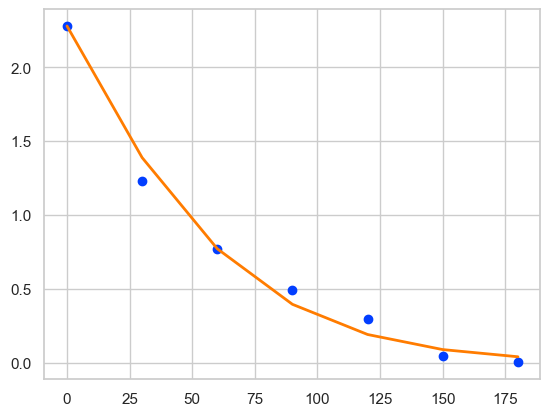

In [9]:
# Initialize parameters
params = Parameters()       # Initialize a Parameters object from lmfit
params.add(name='vmax', value=0.5, min=0.01, max=3.) # Add a parameter to the Parameters object
params.add(name='Km', value=2, min=1, max=3) # Add another parameter to the Parameters object
'''
name = name of parameter
value = initial value of parameter
min = minimal value of parameter when fit is performed
max = maximal value of parameter when fit is performed
vary = False if parameter is constant, Standard -> True
'''

# Perform modeling
perform_modeling(measurement_data, time, params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 7
    # variables        = 2
    chi-square         = 0.03831647
    reduced chi-square = 0.00766329
    Akaike info crit   = -32.4544987
    Bayesian info crit = -32.5626784
[[Variables]]
    vmax:  0.11673413 +/- 0.11812569 (101.19%) (init = 0.09)
    Km:    4.99999979 +/- 12.5774920 (251.55%) (init = 2.4)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.999


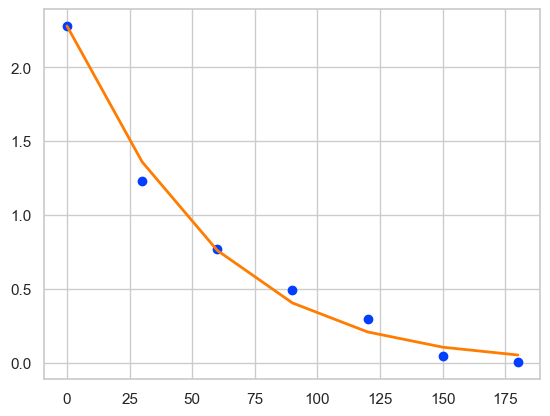

In [10]:
# Initialize parameters
params = Parameters() # Initialize a Parameters object from lmfit
params.add(name='vmax', value=0.09, min=0.02, max=0.12) # Add a parameter to the Parameters object
params.add(name='Km', value=2, min=2.4, max=5) # Add another parameter to the Parameters object
'''
name = name of parameter
value = initial value of parameter
min = minimal value of parameter when fit is performed
max = maximal value of parameter when fit is performed
vary = False if parameter is constant, Standard -> True
'''

# Perform modeling
perform_modeling(measurement_data, time, params)

## Additional information

### Pretty print

If pretty printing the experiment is necessary 

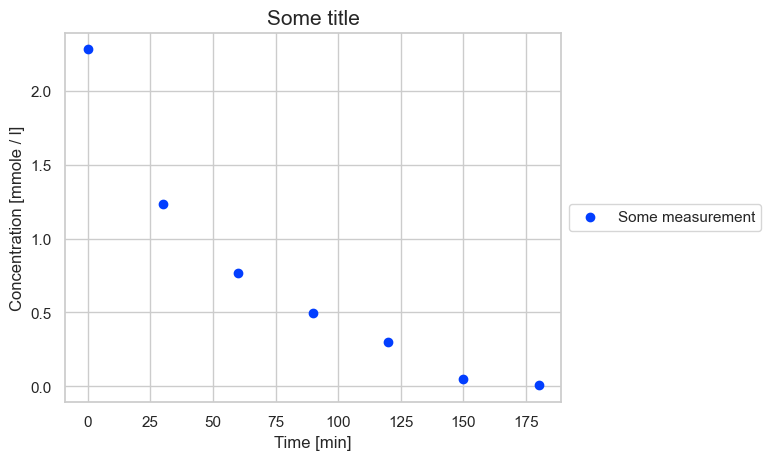

In [11]:
plt.scatter(time, measurement_data, label='Some measurement') # Declare the data that should be plotted
plt.xlabel('Time [min]') # Set a x-axis label
plt.ylabel('Concentration [mmole / l]') # Set a y-axis label
plt.title('Some title', fontsize=15) # Set a title with specific fontsize
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # A legend outside the plot. Label is shown in legend
plt.show() # Print the plot

### Get some meta information